In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
import utils

#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import pandas as pd
import numpy as np
import json
import subprocess

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image

In [21]:
import nibabel as nib
from nilearn.image import concat_imgs, mean_img
from fsl.wrappers import concatxfm,applyxfm

In [3]:
####################
# Setup FSL path
####################
utils.loadFSL()
################
# Start FSLeyes 
################
fsleyesDisplay = utils.FSLeyesServer()
fsleyesDisplay.show()

Gtk-Message: 09:38:37.206: Failed to load module "canberra-gtk-module"

(ipykernel_launcher.py:4809): Gtk-CRITICAL **: 09:38:37.352: gtk_window_resize: assertion 'height > 0' failed


In [4]:
dataset_id= 'ds000171'
subject = 'control01'
subjectID = 'control01'

#path to save
sample_path = "dataset"
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

subject_dir = 'sub-{}'.format(subject)

print_dir_tree(bids_root,5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- .ipynb_checkpoints/
|------ T1w-checkpoint.json
|------ dataset_description-checkpoint.json
|------ task-music_bold-checkpoint.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mask_handmodif.nii.gz
|--------------- sub-control01_T1w_mni.mat
|--------------- sub-control01_T1w_mni.nii.gz
|--------------- sub-control01_T1w_mni_SyN.nii.gz
|------------ fmap/
|------------ func

# ICA

In [5]:
file_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_all_task_bold_moco_smoothed-6mm.nii.gz')
fmri_img = nib.load(file_path)

print(fmri_img.shape)

(80, 80, 50, 315)


In [6]:
# Get affine transform -- check nibabel library for more info!
affine = fmri_img.affine
x = fmri_img.shape[0]
y = fmri_img.shape[1]
z = fmri_img.shape[2]

N_vol= fmri_img.shape[3]
N_subj=1 
N_tot=N_vol*N_subj

# Initialize X
X = np.zeros((N_tot,x*y*z)) # total_timepoints x voxel_num

data_4D = fmri_img.get_fdata() # get the 4D data

# Reshape data to 2D : (timepoints, voxels)
X = data_4D.reshape(-1, N_vol).T

X = zscore(X, axis = 1)
X = np.nan_to_num(X,0) # nan to 0s
print("X matrix size: ", X.shape)

X matrix size:  (315, 320000)


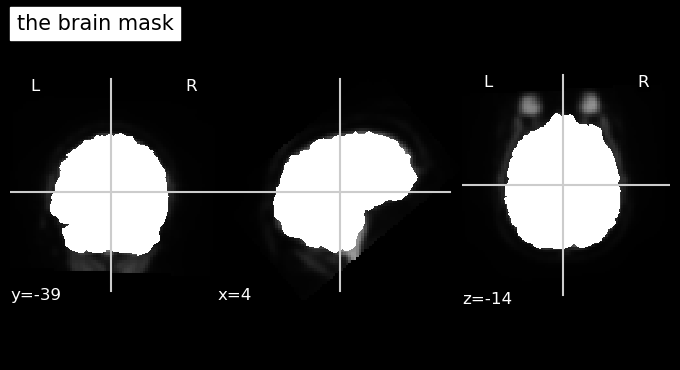

In [7]:
# Build brain mask to restrict analysis within the brain
mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-{}_T1w_mask.nii.gz'.format(subjectID))
masker = NiftiMasker(mask_img=mask_path)
mean_img_ = mean_img(fmri_img),
plot_stat_map(mask_path, black_bg=True,bg_img=mean_img_[0], title='the brain mask', colorbar=False,)

In [8]:
#fsleyesDisplay.load(path_func_img)
#fsleyesDisplay.load(icbms.mask)
#fsleyesDisplay.load(betted_brain_path)
#fsleyesDisplay.load(resulting_mask_path)

In [9]:
# Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [4,]

#* We will transpose the matrix X so that ICA algorithm operates on the voxels dimension.
#* In other words, the estimated sources (S) should be have dimensionality [#voxels]

for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)

    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)

    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 4
Running FastICA with n = 4 components
(320000, 4)
Done


In [10]:
print("The shape of the estimated Sources is: {}".format(S_.shape))

The shape of the estimated Sources is: (320000, 4)


In [11]:
# anatomical ref
resultAnts = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mni_SyN.nii.gz')
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
skull_stripped_t1 = betted_brain_path

## plot the components

Number of components:  4


/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


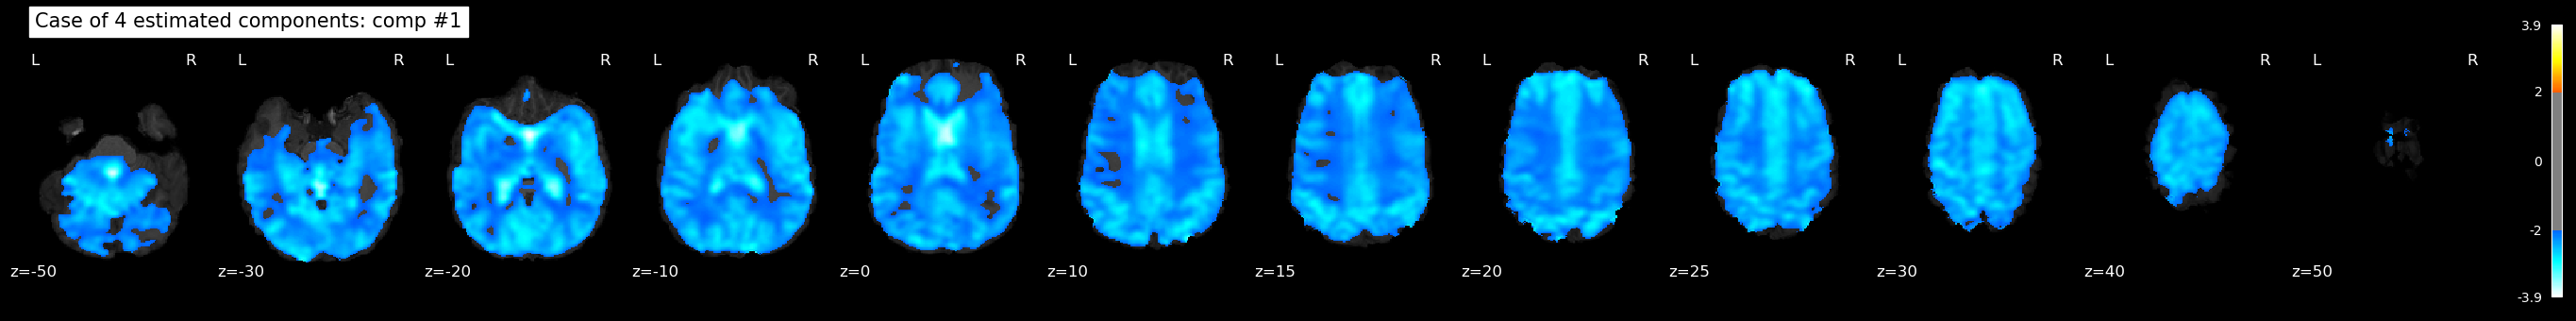

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


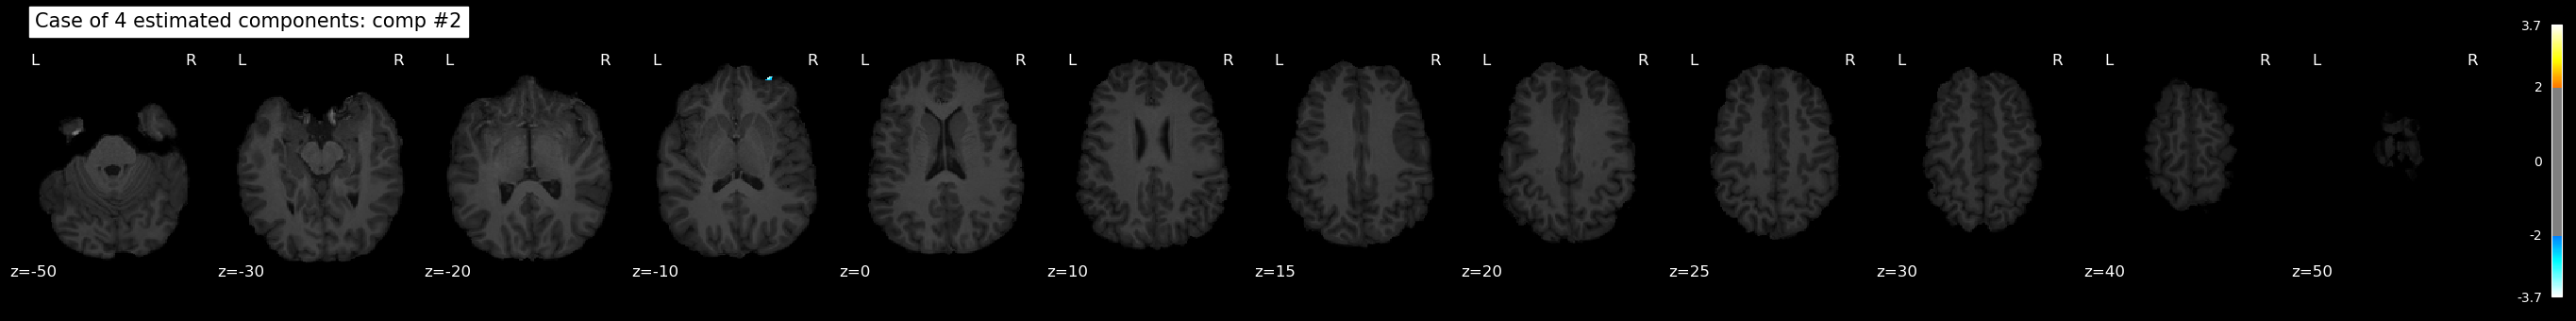

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


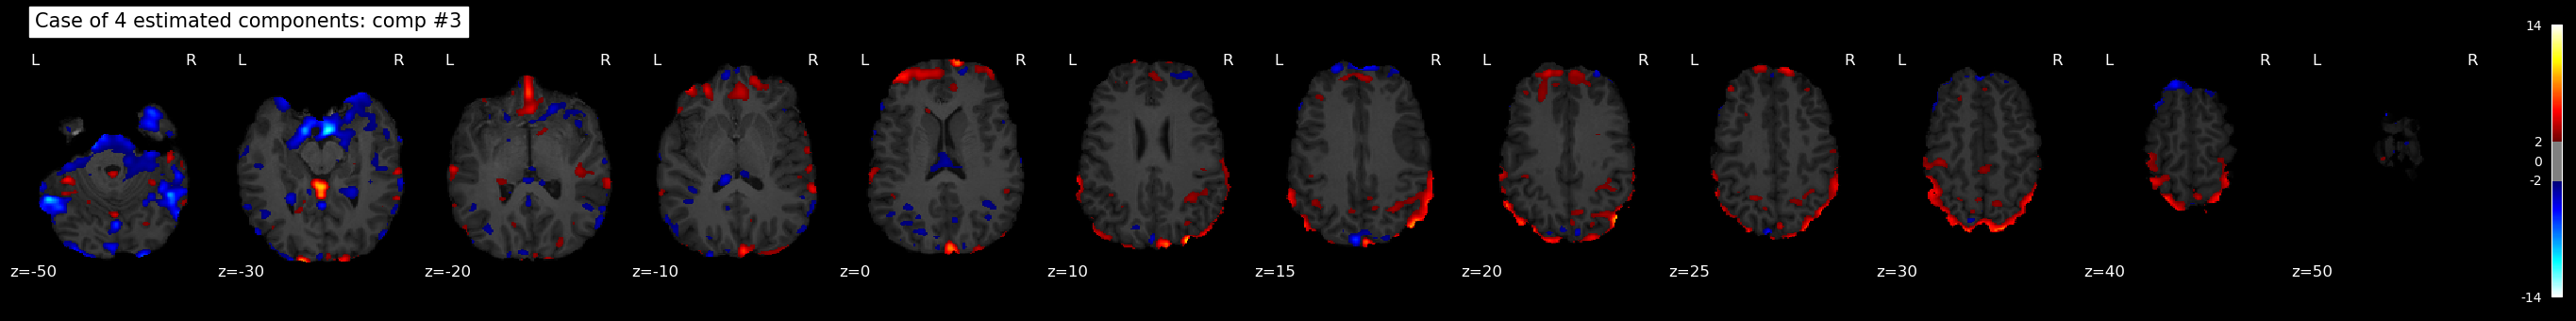

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


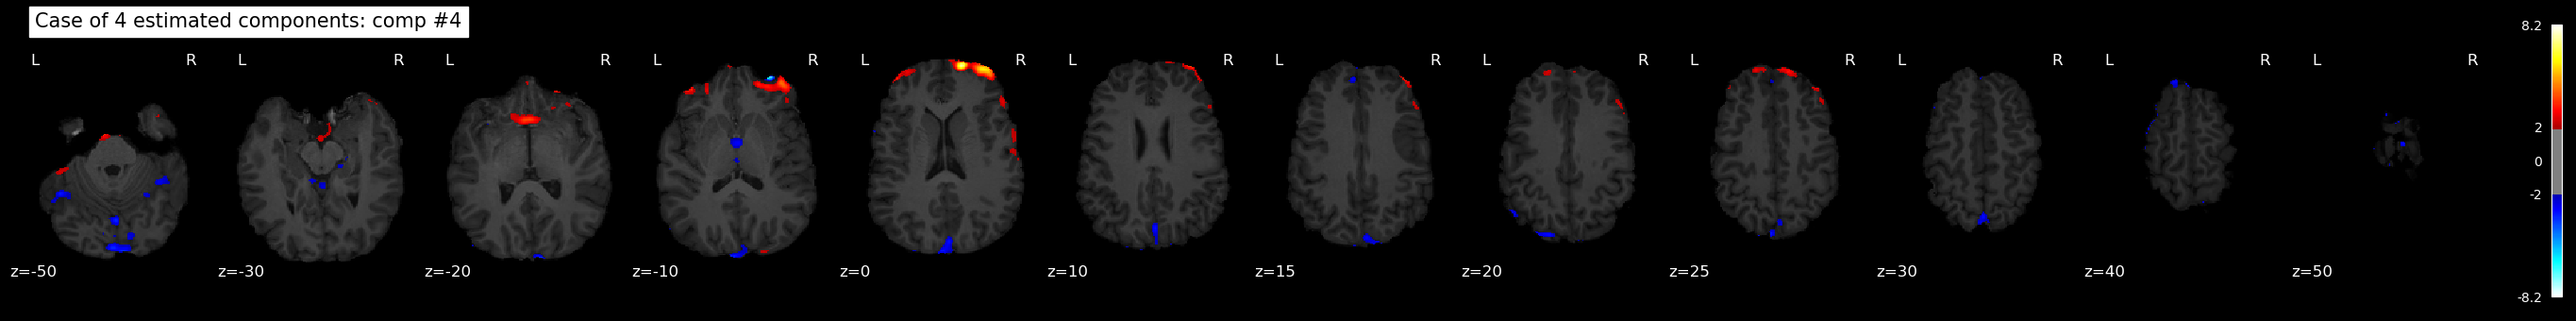

In [14]:
# Plot the group-level independent components for the different number of requested components.
## Here you can use only 3 components to reduce the plots

Result = []
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(4, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        Result.append(masked_)
        plot_stat_map(masked_, display_mode="z",cut_coords=[-50,-30,-20,-10,0,10,15,20,25,30,40,50], title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=skull_stripped_t1,)
        output_file= op.join(bids_root, "ICA_components_{}_n_{}.png".format(idx,n))
        plt.show()

Number of components:  4


/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


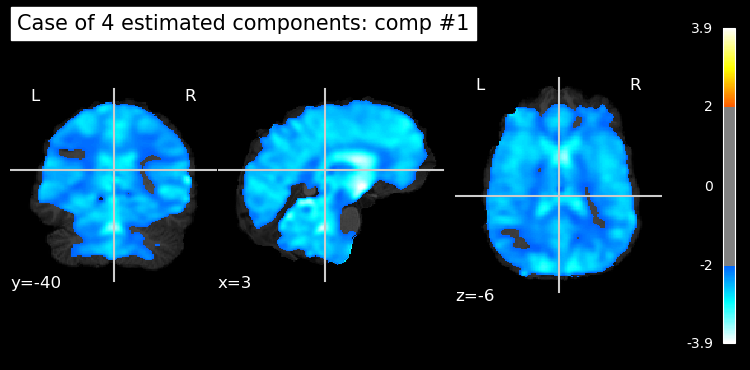

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


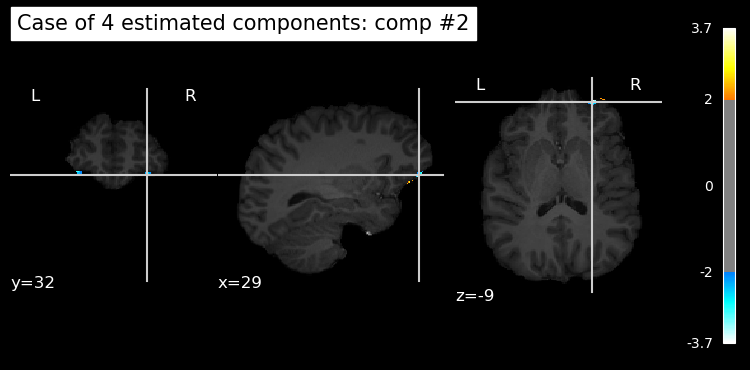

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


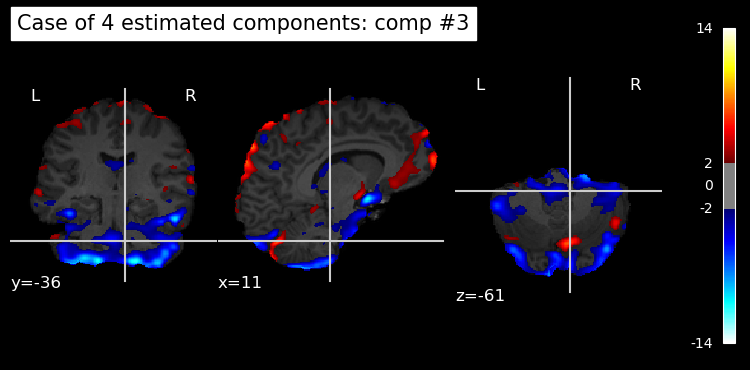

/opt/conda/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


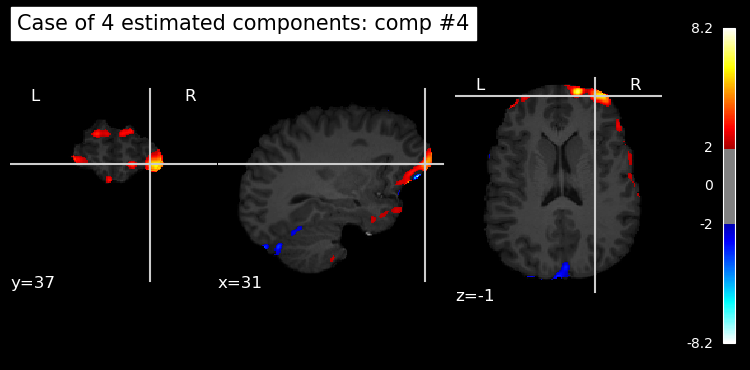

In [13]:
# Plot the group-level independent components for the different number of requested components.
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=skull_stripped_t1,)
        #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

In [18]:
Result

In [23]:
func_to_mni_mat = op.join(preproc_root, 'sub-{}'.format(subjectID), 'func', 'sub-{}_all_transforms.mat'.format(subjectID))
reference = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz'))

for i in range(len(Result)) :
    print("component :",i)
    ica_component = op.join(preproc_root,  'sub-{}'.format(subjectID), 'func', 'sub-{}_icacompoment_{}.nii.gz'.format(subjectID,i))
    nib.save(Result[i],ica_component)
    
    ica_component_mni = op.join(preproc_root,  'sub-{}'.format(subjectID), 'func', 'sub-{}_icacompoment_{}_mni.nii.gz'.format(subjectID,i))
    applyxfm(src=ica_component,ref=reference,mat =func_to_mni_mat,out=ica_component_mni)

component : 0
component : 1
component : 2
component : 3


Number of components:  4


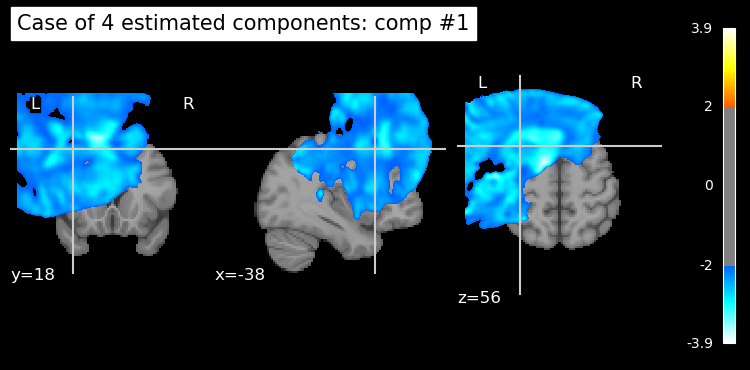

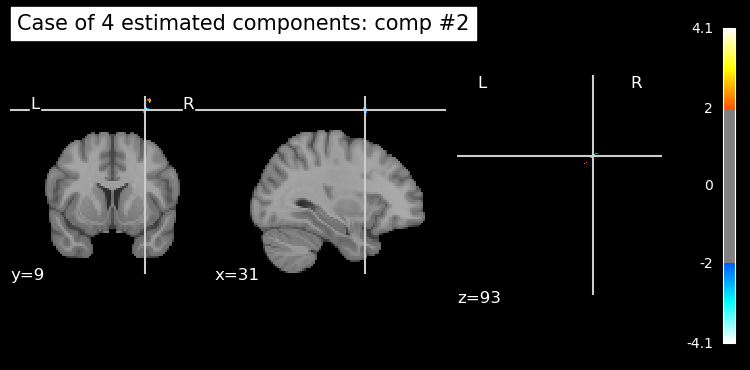

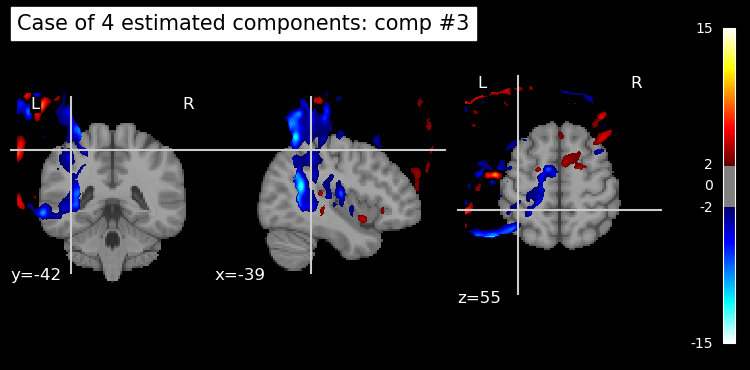

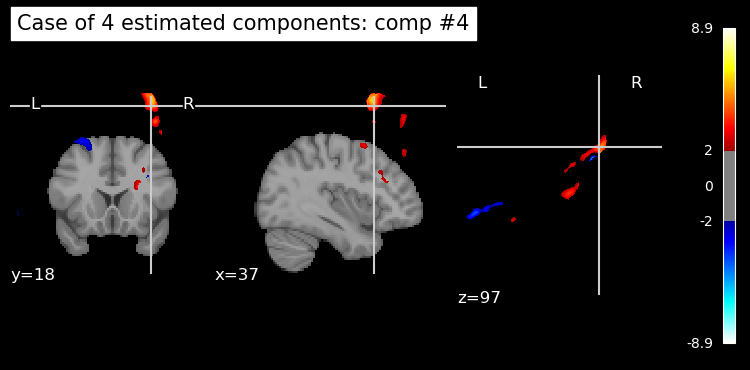

In [24]:
# Plot the group-level independent components for the different number of requested components.
for n in nb_components:
    print('Number of components: ',n)
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        ica_component_mni = op.join(preproc_root,  'sub-{}'.format(subjectID), 'func', 'sub-{}_icacompoment_{}_mni.nii.gz'.format(subjectID,idx))
        plot_stat_map(ica_component_mni, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s))
        #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()